# Generate HTML reports with D3 graphs using Python, Plotly, and Pandas

You can download the example report that this script generate from this link.

<a href="d3.js">d3.js</a> is an amazing JavaScript library for creating interactive, online graphics and charts. Plotly lets you create d3.js charts using Python, R, or MATLAB. This IPython notebook shows you how to embed these charts in an HTML report that you can then share by email or <a href="">host on a website</a>.

Once you've created your report generation script, you can automate it with a task scheduler like <a href="http://moderndata.plot.ly/update-plotly-charts-with-cron-jobs-and-python/">cron</a> on a Ubuntu server, and even email it email it to yourself or your team with the Python <a href="https://docs.python.org/2/library/smtplib.html">smtplib</a> library.

In [153]:
import plotly as py
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import time as dt_tm
from datetime import date as dt_date

import plotly.plotly as py
import plotly.tools as plotly_tools
from plotly.graph_objs import *

import os
import tempfile
os.environ['MPLCONFIGDIR'] = tempfile.mkdtemp()
from matplotlib.finance import quotes_historical_yahoo
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

from IPython.display import HTML

py.sign_in("jackp", "XXXX")

## Step 1: Generate 2 graphs and 2 tables for report with Plotly Python client

### First graph: 2014 Apple stock data with moving average

Let's grab Apple stock data using the <a href="http://matplotlib.org/api/finance_api.html">matplotlib finance</a> model from 2014, then take a moving average with a <a href="http://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html">numpy convolution</a>.

In [154]:
x = []
y = []
ma = []

def moving_average(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

date1 = dt_date( 2014, 1, 1 )
date2 = dt_date( 2014, 12, 12 )
quotes = quotes_historical_yahoo('AAPL', date1, date2)
if len(quotes) == 0:
    print "Couldn't connect to yahoo trading database"
else:
    dates = [q[0] for q in quotes]
    y = [q[1] for q in quotes]
    for date in dates:
        x.append(datetime.fromordinal(int(date))\
                .strftime('%Y-%m-%d')) # Plotly timestamp format
    ma = moving_average(y, 10)

Now graph the data with Plotly. See here for Plotly's <a href="https://plot.ly/python/line-and-scatter/">line plot syntax</a> and here for <a href="https://plot.ly/python/getting-started/">getting started</a> with the Plotly Python client.

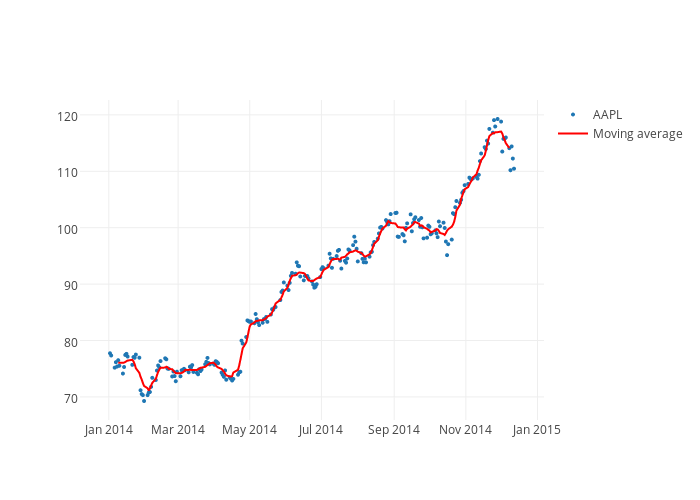

In [155]:
xy_data = Scatter( x=x, y=y, mode='markers', marker=Marker(size=4), name='AAPL' )
# vvv clip first and last points of convolution
mov_avg = Scatter( x=x[5:-4], y=ma[5:-4], \
                  line=Line(width=2,color='red',opacity=0.5), name='Moving average' )
data = Data([xy_data, mov_avg])

py.iplot(data, filename='apple stock moving average')

Save the plot URL - we'll use it when generating the report later.

In [157]:
first_plot_url = py.plot(data, filename='apple stock moving average', auto_open=False,)
print first_plot_url

https://plot.ly/~jackp/1841


### Second graph: Scatter matrix of 2014 technology and CPG stocks

Let's use the Pandas package and Plotly subplots to compare different tech. and CPG stocks in 2014.<br>
This graph was inspired by <a href="http://nbviewer.ipython.org/github/twiecki/financial-analysis-python-tutorial/blob/master/1.%20Pandas%20Basics.ipynb">this IPython notebook</a> and GitHub user <a href="https://github.com/twiecki">twiecki</a>.

In [5]:
tickers = ['AAPL', 'GE', 'IBM', 'KO', 'MSFT', 'PEP']
prices = []
for ticker in tickers:
    quotes = quotes_historical_yahoo(ticker, date1, date2)
    prices.append( [q[1] for q in quotes] )

We have all the stock prices in a list of lists - use the code snippet below to convert this into a Pandas dataframe.

In [6]:
df = pd.DataFrame( prices ).transpose()
df.columns = tickers
df.head()

,AAPL,GE,IBM,KO,MSFT,PEP
0,77.746778,26.907695,182.770157,39.926650,36.354938,80.626950
1,77.352163,26.578632,181.429182,39.493584,36.212300,79.843327
2,75.193398,26.716354,182.712734,39.303899,35.870869,79.922217
3,76.158839,26.543525,181.968752,39.297371,35.362131,80.323900
4,75.389380,26.415215,184.837731,39.265478,35.043624,81.017502


Use Plotly's <a href="https://plot.ly/python/overview/">get_subplots()</a> routine to generate an empty matrix of 6x6 subplots. We'll fill these in by plotting all stock ticker combinations against each other (ie, General Electric stock versus Apple stock) 

In [122]:
fig = plotly_tools.get_subplots(rows=6, columns=6, print_grid=True, horizontal_spacing= 0.05, vertical_spacing= 0.05)

This is the format of your plot grid!
[31]	[32]	[33]	[34]	[35]	[36]	
[25]	[26]	[27]	[28]	[29]	[30]	
[19]	[20]	[21]	[22]	[23]	[24]	
[13]	[14]	[15]	[16]	[17]	[18]	
[7]	[8]	[9]	[10]	[11]	[12]	
[1]	[2]	[3]	[4]	[5]	[6]	



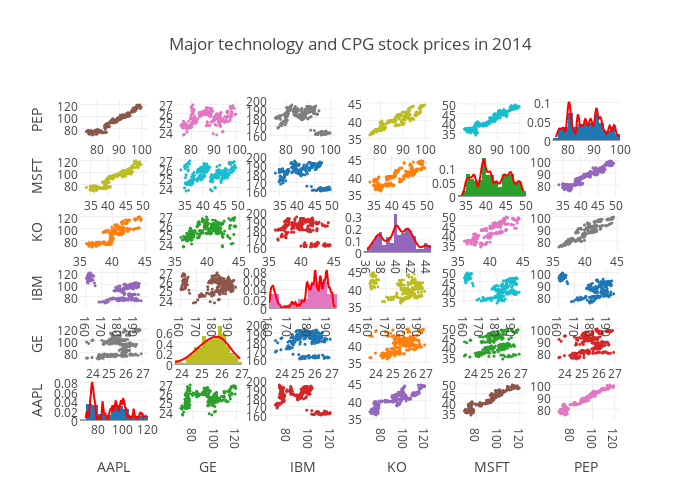

In [143]:
def kde_scipy(x, x_grid, bandwidth=0.4, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # From https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

subplots = range(1,37)
sp_index = 0
data = []
for i in range(1,7):
    x_ticker = df.columns[i-1]
    for j in range(1,7):
        y_ticker = df.columns[j-1]
        if i==j: 
            x = df[x_ticker]
            x_grid = np.linspace(x.min(), x.max(), 100)
            sp = [ Histogram( x=x, histnorm='probability density' ), \
                  Scatter( x=x_grid, y=kde_scipy( x.as_matrix(), x_grid ), \
                          line=Line(width=2,color='red',opacity='0.5') ) ]
        else:
            sp = [ Scatter( x=df[x_ticker], y=df[y_ticker], mode='markers', marker=Marker(size=3) ) ]
        
        for ea in sp:
            ea.update( name='{0} vs {1}'.format(x_ticker,y_ticker),\
                      xaxis='x{}'.format(subplots[sp_index]),\
                      yaxis='y{}'.format(subplots[sp_index])
            )
        sp_index+=1
        data += sp

# Add x and y labels
left_index = 1
bottom_index = 1
for tk in tickers:
    fig['layout']['xaxis{}'.format(left_index)].update( title=tk )
    fig['layout']['yaxis{}'.format(bottom_index)].update( title=tk )
    left_index=left_index+1
    bottom_index=bottom_index+6
    
# Remove legend by updating 'layout' key
fig['layout'].update(showlegend=False,height=1000,width=1000, title='Major technology and CPG stock prices in 2014')
fig['data'] = Data(data)
py.iplot(fig, height=1000, width=1000, filename='Major technology and CPG stock prices in 2014 - scatter matrix')

Save the plot URL - we'll use it when generating the report later.

In [145]:
second_plot_url = py.plot(fig, height=1000, width=1000, auto_open=False,\
                          filename='Major technology and CPG stock prices in 2014 - scatter matrix')
print second_plot_url

https://plot.ly/~jackp/2019


### 2 summary tables - One using Pandas and one using HTML

First table: Use Pandas <a href="http://pandas.pydata.org/pandas-docs/version/0.15.1/generated/pandas.DataFrame.to_html.html">to_html()</a> routine to convert Pandas data frame to HTML table. Replace default table styling with <a href="http://getbootstrap.com/css">Bootstrap</a> table styling.

In [175]:
summary_table_1 = df.describe()
summary_table_1 = summary_table_1\
    .to_html()\
    .replace('<table border="1" class="dataframe">','<table class="table table-striped">') # use bootstrap styling

Second table: Build table as an HTML string. Use <a href="http://getbootstrap.com/css">Bootstrap</a> for table styling.

In [135]:
summary_table_2 = '''<table class="table table-striped">
<th>Ticker</th><th>Full name</th>
<tr>
    <td>AAPL</td>
    <td><a href="http://finance.yahoo.com/q?s=AAPL">Apple Inc</a></td>
</tr>
<tr>
    <td>GE</td>
    <td><a href="http://finance.yahoo.com/q?s=GE">General Electric Company</a></td>
</tr>
<tr>
    <td>IBM</td>
    <td><a href="http://finance.yahoo.com/q?s=IBM">International Business Machines Corp.</a></td>
</tr>
<tr>
    <td>KO</td>
    <td><a href="http://finance.yahoo.com/q?s=KO">The Coca-Cola Company</a></td>
</tr>
<tr>
    <td>MSFT</td>
    <td><a href="http://finance.yahoo.com/q?s=MSFT">Microsoft Corporation</a></td>
</tr>
<tr>
    <td>PEP</td>
    <td><a href="http://finance.yahoo.com/q?s=PEP">Pepsico, Inc.</a></td>
</tr>
</table>
'''
HTML(summary_table_2)

AAPL,Apple Inc
GE,General Electric Company
IBM,International Business Machines Corp.
KO,The Coca-Cola Company
MSFT,Microsoft Corporation
PEP,"Pepsico, Inc."


## Step 2: Generate HTML report as a string and write to file

This is the last step. We have all of the plots and tables that we want to include in the report - now we build an HTML string with the plots and tables embedded.<br>Notice that the <a href="http://getbootstrap.com/css">Bootstrap</a> css library is included in the &lt;head&gt; for styling.

In [184]:
html_string = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h1>2014 technology and CPG stock prices</h1>

        <!-- *** Section 1 *** --->
        <h2>Section 1: Apple Inc. (AAPL) stock in 2014</h2>
        <iframe width="1000" height="550" frameborder="0" seamless="seamless" scrolling="no" \
src="''' + first_plot_url + '''.embed?width=800&height=550"></iframe>
        <p>Apple stock price rose steadily through 2014.</p>
        
        <!-- *** Section 2 *** --->
        <h2>Section 2: AAPL compared to other 2014 stocks</h2>
        <iframe width="1000" height="1000" frameborder="0" seamless="seamless" scrolling="no" \
src="''' + second_plot_url + '''.embed?width=1000&height=1000"></iframe>
        <p>GE had the most predictable stock price in 2014. IBM had the highest mean stock price. \
The red lines are kernel density estimations of each stock price - the peak of each red lines \
corresponds to its mean stock price for 2014 on the x axis.</p>
        <h3>Reference table: stock tickers</h3>
        ''' + summary_table_2 + '''
        <h3>Summary table: 2014 stock statistics</h3>
        ''' + summary_table_1 + '''
    </body>
</html>'''

Finally, write the html string to a local file.

In [185]:
f = open('/home/jack/report.html','w')
f.write(html_string)
f.close()